In [ ]:
# 练习

1. 代码练习

    * 尝试生成垂直距离小于零的双月数据集，然后使用此数据集训练Rosenblatt感知器模型，记录其代价变化，并可视化。

    * 思考：根据上述训练结果以及决策边界的可视化结果，说明训练Rosenblatt感知器去解决线性不可分问题是否意味着模型完全失效？如果不是，思考在训练时如何确定训练终止条件。

    * 训练感知器模型时，使用到了学习率这个超参数，实际中，学习率是较难确定的超参数之一，为此提出了学习率衰减，请自行学习学习率衰减的原理与实现方法，并实现线性衰减学习率模型应用与Rosenblatt感知器模型的训练中。

    * 在训练模型时，模型训练何时终止并无说明，但由于Rosenblatt感知器模型在线性可分的数据集中一定可以收敛，所以代价会逐步趋于零或等于零，此时即可终止训练，尝试使用代码实现动态终止训练。
    
2. 判断题

    * [×] Rosenblatt感知器只能训练其进行二类别的判别。
    * [√] 对于线性可分的数据集，Rosenblatt感知器一定能够收敛。
    * [√] Rosenblatt（1958）提出感知器作为神经网络中监督学习的第一个模型。
    * [×] 一般的在二分类任务中，Rosenblatt感知器的激活函数输出 0 表示负类，输出 1 表示正类。
    * [√] 均方误差代价函数可用于衡量模型在分类任务中的性能。

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
def dbmoon(N=100, d=-1, r=10, w=2):
    '''生成双月数据集
    
    Args:
        N: 数据集数量
        d: 双月之间的距离
        r: 双月半径
        w: 每个月亮的厚度
        
    Returns:
        返回一个`shape=[N * 2, 2]`的数组，前100个元素表示
        上半月，后100个元素表示下半月。
    '''
    w2 = w / 2
    data = np.empty(0)
    while data.shape[0] < N:
        #generate Rectangular data
        tmp_x = 2 * (r + w2) * (np.random.random([N, 1]) - 0.5)
        tmp_y = (r + w2) * np.random.random([N, 1])
        tmp = np.concatenate((tmp_x, tmp_y), axis=1)
        tmp_ds = np.sqrt(tmp_x * tmp_x + tmp_y * tmp_y)
        #generate double moon data ---upper
        idx = np.logical_and(tmp_ds > (r - w2), tmp_ds < (r + w2))
        idx = (idx.nonzero())[0]

        if data.shape[0] == 0:
            data = tmp.take(idx, axis=0)
        else:
            data = np.concatenate((data, tmp.take(idx, axis=0)), axis=0)
    
    db_moon = data[0: N, :]
    #generate double moon data ----down
    data_t = np.empty([N, 2])
    data_t[:, 0] = data[0: N, 0] + r
    data_t[:, 1] = -data[0: N, 1] - d
    db_moon = np.concatenate((db_moon, data_t), axis=0)
    return db_moon

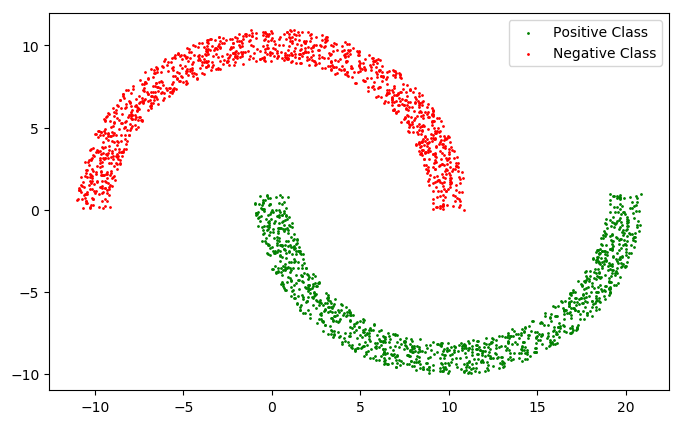

In [7]:
num_example = 2500
x =  dbmoon(N=num_example // 2)
y = np.concatenate([np.ones([num_example // 2]), -np.ones([num_example // 2])])

plt.figure(figsize=(8, 5), dpi=100)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Positive Class')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Negative Class')
plt.legend(loc='best')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# 将数据集打乱并分为训练集与测试集
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=500)

In [9]:
w = np.zeros([2], dtype=np.float32)
b = 0.

def rosenblatt(x):
    z = np.sum(w * x) + b
    if z >= 0:
        return 1
    else:
        return -1

In [10]:
def mse(label, pred):
    return np.average((np.array(label) - np.array(pred)) ** 2)

In [11]:
# 训练模型 2000 次
train_steps = 2000
# 摘要频率
summary_step = 50
# 摘要，记录训练中的代价变化
summary = np.empty([train_steps // summary_step, 2])
# 学习率
lr = 0.1

for i in range(0, train_steps):
    # 评估模型
    if i % summary_step == 0:
        test_out = []
        for j in range(test_y.shape[0]):
            test_out.append(rosenblatt(test_x[j]))
        loss = mse(test_y, test_out)
        idx = int(i / summary_step)
        summary[idx] = np.array([i, loss])
    
    # 取一个训练集中的样本
    one_x, one_y = train_x[i % train_y.shape[0]], train_y[i % train_y.shape[0]]
    # 得到模型输出结果
    out = rosenblatt(one_x)
    # 更新权值
    w = w + lr * (one_y - out) * one_x
    b = b + lr * (one_y - out)

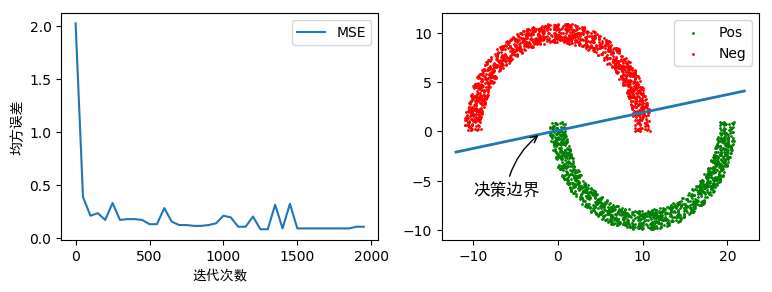

In [12]:
plt.figure(figsize=(9, 3), dpi=100)

plt.subplot(1, 2, 1)
plt.plot(summary[:, 0], summary[:, 1], label='MSE')
plt.legend(loc='best')
plt.xlabel('迭代次数', fontproperties='SimHei')
plt.ylabel('均方误差', fontproperties='SimHei')

plt.subplot(1, 2, 2)
plt.scatter(x[num_example // 2:, 0], x[num_example // 2:, 1], 1, color='green', label='Pos')
plt.legend(loc='best')
plt.scatter(x[: num_example // 2, 0], x[: num_example // 2, 1], 1, color='red', label='Neg')
plt.legend(loc='best')
left_coord_y = (-b - (-12) * w[0]) / w[1]
right_coord_y = (-b - (22) * w[0]) / w[1]
plt.plot([-12, 22], [left_coord_y, right_coord_y], linewidth=2)

plt.annotate(
    '决策边界', xy=(-2, -0.2), xytext=(-10., -6.5), 
     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.2"), 
     fontproperties='SimHei', fontsize=12)

plt.show()